<a href="https://colab.research.google.com/github/Kriszti8828/6het/blob/mergel/beadando_maxmin_ipynb_m%C3%A1solata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Adatbázisok importálása
df_dbe=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/DBE.csv')
df_pbj=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/PBJ.csv')
df_xlb=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/XLB.csv')
df_bil=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/BIL.csv')
df_qqq=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/QQQ.csv')


In [ ]:
#YC importálása
df_yc=pd.read_csv('/content/drive/My Drive/numpu4/beadando_etfs/DGS3MO.csv')
#df_yc.head()
#az értelmezhetetlen karakter eliminációja, számmá alakítás
df_yc['DGS3MO']=df_yc['DGS3MO'].replace('.',10000).astype(float)
df_yc['DGS3MO']=df_yc['DGS3MO'].astype(float)

for i in range(len(df_yc)):
  if df_yc['DGS3MO'][i]==10000:
    df_yc['DGS3MO'][i]=(df_yc['DGS3MO'][i-1]+df_yc['DGS3MO'][i+1])/2
  if df_yc['DGS3MO'][i]==0:
    df_yc['DGS3MO'][i]==df_yc['DGS3MO'][i-1]

<ipython-input-100-e1189bccf5d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yc['DGS3MO'][i]=(df_yc['DGS3MO'][i-1]+df_yc['DGS3MO'][i+1])/2


In [ ]:
#A megfelelő hozamok közö dataframebe illesztése
#Az üres df. létrehozása
df_hozam=pd.DataFrame(columns={'Date','dbe','pbj','xlb','bil','qqq','yc'})
#Feltöltés a dátummal
df_hozam['Date']=df_qqq['Date'].copy()

In [ ]:
#Feltöltés az ETF-ek adj. close adatával
df_hozam['dbe']=df_dbe['Adj Close'].copy()
df_hozam['pbj']=df_pbj['Adj Close'].copy()
df_hozam['xlb']=df_xlb['Adj Close'].copy()
df_hozam['bil']=df_bil['Adj Close'].copy()
df_hozam['qqq']=df_qqq['Adj Close'].copy()

#és a hozamgörbével
df_hozam['yc']=df_yc['DGS3MO'].copy()


In [ ]:
#A dátum szerint indexelünk
df_hozam=df_hozam.set_index('Date')
df_hozam.index = pd.to_datetime(df_hozam.index)

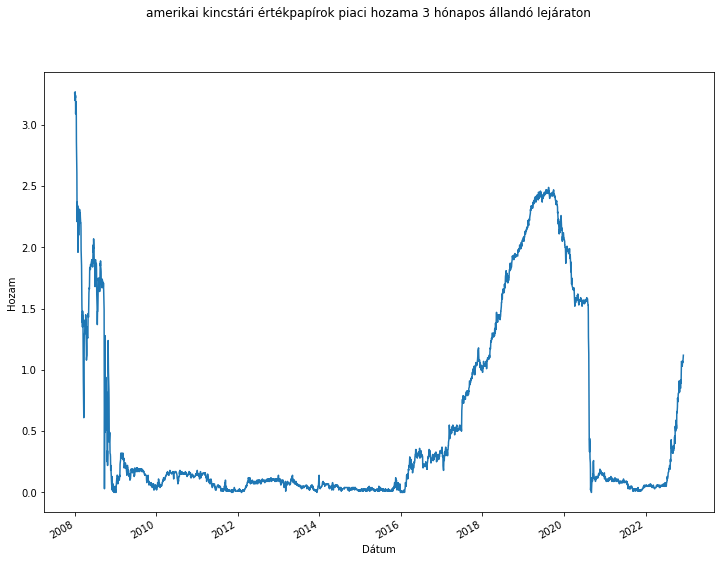

In [ ]:
#Ellenőrzés


plt.figure(figsize=(12, 9))
plt.suptitle('amerikai kincstári értékpapírok piaci hozama 3 hónapos állandó lejáraton')
df_hozam['yc'].plot()
plt.ylabel('Hozam')
plt.xlabel('Dátum')
plt.savefig("yc_hozam.png") 
plt.show()

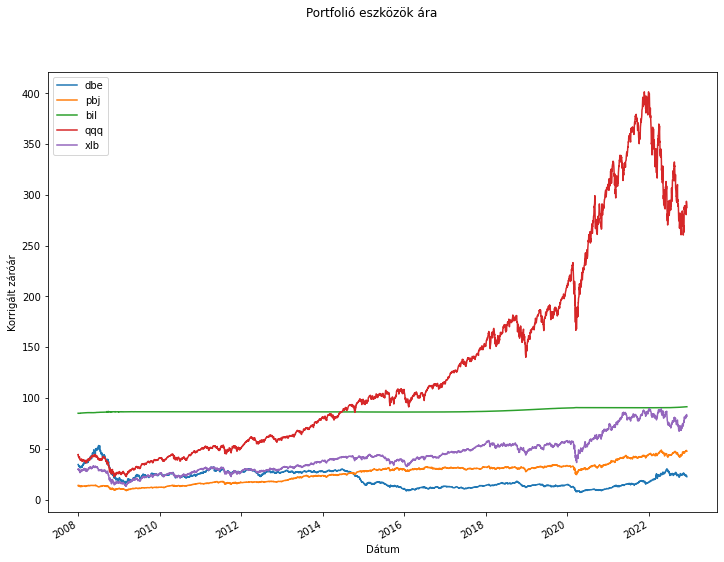

In [ ]:
df_hozam.plot( y=['dbe','pbj','bil','qqq', 'xlb'], figsize=(12,9))
plt.suptitle('Portfolió eszközök ára')
plt.ylabel('Korrigált záróár')
plt.xlabel('Dátum')
plt.savefig("assets-adjclose.png") 
plt.show()

In [ ]:
type(df_hozam['bil'])

pandas.core.series.Series

In [ ]:
sima=[0,1]
sima2=np.array(sima)

In [ ]:
#a hozam kiszámítása (t/(t-1))
df_ret=pd.DataFrame(columns={'dbe','pbj','xlb','bil','qqq','yc'})
df_ret['dbe']=df_hozam['dbe']/df_hozam['dbe'].shift(1)-1
df_ret['pbj']=df_hozam['pbj']/df_hozam['pbj'].shift(1)-1
df_ret['xlb']=df_hozam['xlb']/df_hozam['xlb'].shift(1)-1
df_ret['bil']=df_hozam['bil']/df_hozam['bil'].shift(1)-1
df_ret['qqq']=df_hozam['qqq']/df_hozam['qqq'].shift(1)-1
df_ret['yc']=(df_hozam['yc']+1)/(df_hozam['yc']+1).shift(1)-1


In [ ]:
df_hozam.head(5)

,qqq,xlb,pbj,bil,dbe,yc
Date,,,,,,
2008-01-02,44.299957,29.851694,13.911901,85.052963,34.557426,3.26
2008-01-03,44.484505,30.393787,13.920213,84.997299,34.330193,3.24
2008-01-04,42.533573,29.475840,13.595911,84.978714,34.140842,3.20
2008-01-07,42.331459,29.071068,13.845374,85.052963,33.336082,3.27
2008-01-08,41.232960,28.622932,13.687383,84.997299,33.610649,3.25


In [ ]:
#A dátum szerint indexelünk

df_ret.index = pd.to_datetime(df_ret.index)

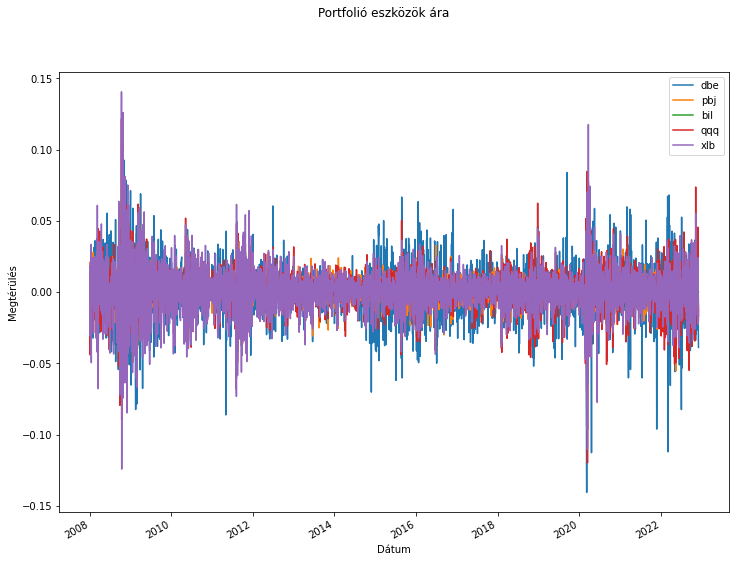

In [ ]:
#Ellenőrzés
df_ret.head(50)
df_ret.plot( y=['dbe','pbj','bil','qqq', 'xlb'], figsize=(12,9))
plt.suptitle('Portfolió eszközök ára')
plt.ylabel('Megtérülés')
plt.xlabel('Dátum')
plt.savefig("assets-return.png") 
plt.show()


In [ ]:
from math import nan
#df_ret['yc'].plot()
for i in range(len(df_ret['yc'])):
  if df_ret['yc'][i]==np.NaN:
    df_ret['yc'][i]=0
  if df_ret['yc'][i]<-100:
    df_ret['yc'][i]=0
  if df_ret['yc'][i]>100:
    df_ret['yc'][i]=0

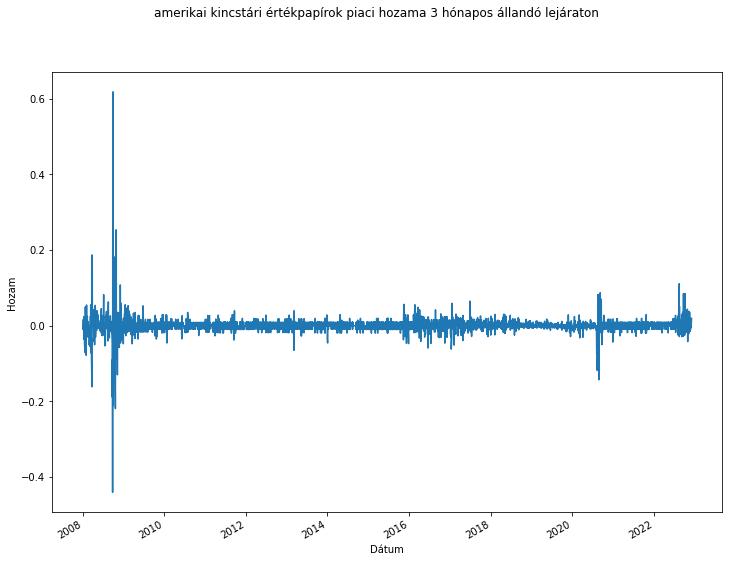

In [ ]:
plt.figure(figsize=(12, 9))
plt.suptitle('amerikai kincstári értékpapírok piaci hozama 3 hónapos állandó lejáraton')
df_ret['yc'].plot()
plt.ylabel('Hozam')
plt.xlabel('Dátum')
plt.savefig("yc_return.png") 
plt.show()

In [ ]:
print(df_ret['yc'][0:252*5].mean()*252)

-0.12107720415312563


In [ ]:
#A végtelen és a 0 adatok kezelése
df_ret=df_ret.replace(np.inf,np.nan).astype(float)

In [ ]:
#Az yc nélküli hozamok, adatbázis
df_hozam2=df_hozam.copy()
#df_hozam2.head()
df_hozam2=df_hozam2.drop(['yc'], axis=1)
df_hozam_gsh=df_hozam2.copy() #Adatbázis a globális Sharpe-rátához
df_hozam_lsh=df_hozam2.copy() #Adatbázis az ablakos Sharpe-rátához

###Sharpe ráta, globális

#####Órai anyag

In [ ]:
#Eszköz metrikák az egyes hozamokra
def asset_metrics(price_df):
  return_asset = price_df/price_df.shift(1)-1 
  mean_asset = return_asset.mean() * 252       #évestett metrika
  std_asset = return_asset.std() * np.sqrt(252)  #évesített szórás
  cov_asset = return_asset.cov() * 252         #évesített
  corr_asset = return_asset.corr()
  return return_asset, mean_asset, std_asset, cov_asset, corr_asset



In [ ]:
#Az adatbázisunkra alkalmazva a metrikák:
ret_asset, mean_asset, std_asset, cov_asset, corr_asset = asset_metrics(df_hozam2)
#kesobbre=asset_metrics(df_hozam2)

In [ ]:
#A szórások az egyes adatsorokra
std_asset

qqq    0.229181
xlb    0.251221
pbj    0.167672
bil    0.004980
dbe    0.286843
dtype: float64

In [ ]:
#N eszköz átlagos hozama, a megfelelő súlyokkal
def calc_nasset_mean(w, mean_return):
  return np.sum(w*mean_return)    #2 vektor elemenkénti szorzata --> összeadjuk

#n eszköz kovarianciája a megfelelő súlyokkal
def calc_nasset_cov(w, cov_matrix):
  return np.sqrt(np.dot(np.dot(w,cov_matrix), w.transpose()))   #np.dot  mátrix szorzat


In [ ]:
#A return és a szórás meghatározása
def calc_nasset(w, mean_return, cov_matrix):
  ret = calc_nasset_mean(w,mean_return)
  std = calc_nasset_cov(w, cov_matrix)
  return ret, std

def calc_nasset_std(w, cov_matrix):
  return np.sqrt(np.dot(np.dot(w,cov_matrix),w.transpose()))

In [ ]:
#Teszt
#A qqq indexét 1-re állítottuk, a többit 0-ra, valóban a qqq szórása és átlagos hozama jön ki
calc_nasset(np.array([0,0,0,1,0]), mean_asset, cov_asset)

(0.00487529085580334, 0.004979813351040106)

In [ ]:
w1s = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(w1s,w1s,w1s,w1s))      #meshgrid = Descrtes-szorzat
#létrehoz egy grid-et = vektorok sorozata
grid = grid.reshape((4,-1)).transpose()       #4 sor, 1.dimenzióban 4 elem, többiben a maradék
grid = np.c_[grid, 1-grid.sum(axis = 1)]

nasset_mean_std = []
for i in range(grid.shape[0]):
  ret, std = calc_nasset(grid[i],mean_asset, cov_asset)
  nasset_mean_std.append((ret, std))

#K: sok adat miatt nagyon lassan fut de lefut (kb 1 perc)

In [ ]:
print(nasset_mean_std)

[(-0.2888538846566863, 1.3086864783105467), (-0.29043695547659654, 1.256579320701733), (-0.2920200262965067, 1.2049586472752478), (-0.2936030971164169, 1.1538897502783187), (-0.2951861679363271, 1.1034492429093075), (-0.2967692387562373, 1.0537273695233915), (-0.2983523095761475, 1.004830815915817), (-0.2999353803960577, 0.9568861111288038), (-0.3015184512159679, 0.9100437090899336), (-0.3031015220358781, 0.8644828147296626), (-0.3046845928557883, 0.8204169569173195), (-0.272075505569557, 1.254822447782178), (-0.27365857638946717, 1.2026199948176697), (-0.2752416472093774, 1.15091823781633), (-0.2768247180292876, 1.0997877931978688), (-0.27840778884919776, 1.0493121802979462), (-0.27999085966910797, 0.9995906037483642), (-0.2815739304890182, 0.9507413739856949), (-0.28315700130892835, 0.9029060898234067), (-0.28474007212883856, 0.8562547025260527), (-0.2863231429487487, 0.8109915448890715), (-0.28790621376865894, 0.7673623120084445), (-0.2552971264824276, 1.2012209578267512), (-0.25688

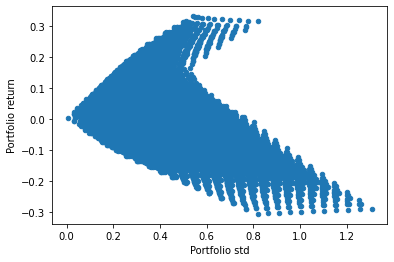

In [ ]:
df = pd.DataFrame(nasset_mean_std)
df.columns = ["Portfolio return", "Portfolio std"]

df.plot.scatter(x= "Portfolio std", y="Portfolio return")

#####Saját próbálkozás

In [ ]:
def minden(price_df,w):
  return_asset = price_df/price_df.shift(1)-1
  mean_asset = return_asset.mean() * 252       #évestett metrika
  std_asset = return_asset.std() * np.sqrt(252)  #évesített szórás
  cov_asset = return_asset.cov() * 252         #évesített
  corr_asset = return_asset.corr()

#Itt jön be a calc nasset mean és cov

  #N eszköz átlagos hozama, a megfelelő súlyokkal
  calc_nasset_mean=np.sum(w*mean_asset)    #2 vektor elemenkénti szorzata --> összeadjuk

  #n eszköz kovarianciája a megfelelő súlyokkal
  calc_nasset_cov=np.sqrt(np.dot(np.dot(w,cov_asset), w.transpose()))   #np.dot  mátrix szorzat

  #A return és a szórás meghatározása
  ret = calc_nasset_mean
  std = calc_nasset_cov
  #Kockázatmentes hozamgörbe  
  
 
  return ret, std

In [ ]:
ww=np.array([0,0,0,1,0])
#A fenti függvény behívása
rreturn, standev =minden(df_hozam_gsh, ww)


In [ ]:
print(rreturn)
print(standev)
print(rreturn/standev)

0.00487529085580334
0.004979813351040106
0.9790107604705836


#####Optimalizálás

In [ ]:
def elsoopt(ww):
  a1,a2=minden(df_hozam_gsh,ww)
  Sh_rate=(a1-0.01)/a2
  return Sh_rate

In [ ]:
fun1 = lambda x: 100-elsoopt(x) #ide proba(x) is jöhet tesztelni

In [ ]:
bounds=((0,None),(0,None),(0,None),(0,None),(0,None))
cons=({'type': 'eq', 'fun': lambda ww: np.sum(ww)-1})

In [ ]:
#Az optimalizálás (~3 min volt nekem)
megoldas1=scipy.optimize.minimize(fun1, (0.5,0.2,0.1,0.0,0), method='SLSQP',
                        bounds=bounds,
                        constraints=cons)

In [ ]:
print(megoldas1)

     fun: 99.37329825675654
     jac: array([-0.04988003,  0.12882519, -0.04905319, -0.02606106,  0.24208546])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([7.17851417e-01, 1.80194401e-16, 2.82148583e-01, 1.10154941e-16,
       0.00000000e+00])


In [ ]:
rreturn, standev=minden(df_hozam_gsh,megoldas1['x'])

print((rreturn-0.1)/standev)

print(sum(megoldas1['x']))

0.17988009869908486
0.9999999999999999


##Csúszóablakos Sharpe-ráta

In [ ]:
#logaritmizálás

df_log=pd.DataFrame(columns={'dbe','pbj','xlb','bil','qqq','yc'}) #A új adatbázis a logaritmizált változóknak
for i in range(len(df_log.columns)):
  df_log[df_log.columns[i]]=np.log(df_hozam[df_log.columns[i]]/df_hozam[df_log.columns[i]].shift(1)) #A log(x_t/x_(t-1)) képlet alapján


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


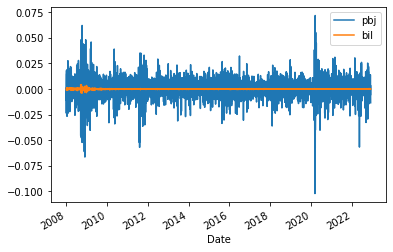

In [ ]:
#Ellenőrzés
#print(df_log.head())
df_log[['pbj', 'bil']].plot()
plt.show()
#a food commodity láthatóan sokkal volatilisebb, mint a fixed income

In [ ]:
#for ciklus 5 évre
df_gordul=pd.DataFrame(columns={}) #dataframe a gördülő volatilitáshoz

In [ ]:
#Feltöltjük az időadatokkal
df_gordul['start']=np.zeros(len(df_hozam2)-5*252)
df_gordul['stop']=np.zeros(len(df_hozam2)-5*252)
#df_gordul['Date']=np.zeros(len(df_hozam)-5*252)
for i in range(len(df_hozam.index)-5*252):
  df_gordul['start'][i+1]=df_bil['Date'][i+1]
  df_gordul['stop'][i]=df_bil['Date'][5*252+i]
#  df_gordul['Date'][i]=df_bil['Date'][5*252+i]



<ipython-input-68-06cf2b025879>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gordul['stop'][i]=df_bil['Date'][5*252+i]
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#Dátummá alakítás
#df_gordul=df_gordul.set_index('Date')
#df_gordul.index = pd.to_datetime(df_gordul.index)

In [ ]:
#Ellenőrzés
print(df_gordul.head(-3))

           start        stop
0            0.0  2013-01-03
1     2008-01-03  2013-01-04
2     2008-01-04  2013-01-07
3     2008-01-07  2013-01-08
4     2008-01-08  2013-01-09
...          ...         ...
2491  2017-11-21  2022-11-23
2492  2017-11-22  2022-11-25
2493  2017-11-24  2022-11-28
2494  2017-11-27  2022-11-29
2495  2017-11-28  2022-11-30

[2496 rows x 2 columns]


In [ ]:
#Feltöltés a return és volatility adatokkal
df_alap=df_hozam2[df_gordul['start'][1]:df_gordul['stop'][1]].copy()
print(df_alap.head(30))

                  qqq        xlb        pbj        bil        dbe
Date                                                             
2008-01-03  44.484505  30.393787  13.920213  84.997299  34.330193
2008-01-04  42.533573  29.475840  13.595911  84.978714  34.140842
2008-01-07  42.331459  29.071068  13.845374  85.052963  33.336082
2008-01-08  41.232960  28.622932  13.687383  84.997299  33.610649
2008-01-09  42.111755  28.803635  13.803798  84.941589  33.307674
2008-01-10  42.173275  29.193937  14.011689  84.978714  32.947899
2008-01-11  41.347191  28.897604  13.654121  85.015854  32.559715
2008-01-14  42.067822  29.866159  13.670752  85.090065  33.165657
2008-01-15  40.907822  29.049393  13.404653  85.071541  32.521847
2008-01-16  40.468414  28.080832  13.321498  85.071541  32.038994
2008-01-17  39.905983  26.693056  12.972244  85.034409  31.783360
2008-01-18  39.853268  26.996632  13.063713  85.090065  32.048458
2008-01-22  38.825066  26.750870  12.830883  85.127197  31.669750
2008-01-23

In [ ]:
#For ciklussal, függvénnyel:
def gordulret(df1,df2,w): #df1: a df_gordul üresen, df2: ahonnan az adatokat vesszük
  df_gordul_ret=df1.copy()
  w=np.array(w)
  df_gordul_ret['hozam']=np.zeros
  df_gordul_ret['szoras']=np.zeros
  df_gordul_ret['kockment']=np.zeros
  for i in range(len(df_gordul_ret)-1):
    df_alap=df2[df_gordul_ret['start'][i+1]:df_gordul_ret['stop'][i+1]]
    df_gordul_ret['hozam'][i],df_gordul_ret['szoras'][i]=minden(df_alap,w)
    df_gordul_ret['kockment'][i]=(df_ret['yc'][df_gordul_ret['start'][i+1]:df_gordul_ret['stop'][i+1]]).mean()*252 #évesített
  return df_gordul_ret


In [ ]:
ww=[0,0,0.5,0.5,0]
www=[0,1,0,0,0]

In [ ]:

teszt2=gordulret(df_gordul,df_hozam_lsh,ww)

In [ ]:
#Ellenőrzés
print(teszt2.head(5))
print((0.034371--0.126212)/0.279417)

        start        stop     hozam    szoras  kockment
0         0.0  2013-01-03   0.03853  0.095884  -0.12715
1  2008-01-03  2013-01-04  0.040106  0.095753 -0.126212
2  2008-01-04  2013-01-07  0.038184   0.09566  -0.12066
3  2008-01-07  2013-01-08  0.039784  0.095623 -0.125791
4  2008-01-08  2013-01-09  0.039293   0.09561 -0.124855
0.5747073370625265


In [ ]:
#Kiszámítja egy sor Sharpe rátáját
def sor(qqq,index):
  df=gordulret(df_gordul,df_hozam_lsh,qqq)
  hozam=df['hozam'][index]
  szoras=df['szoras'][index]
  kockment=df['kockment'][index]
  sharpe=(hozam-kockment)/szoras
  return sharpe

In [ ]:
#Célfüggvény
def celf(qqq):
  return sor(qqq,1)

In [ ]:
sor([])

TypeError: ignored

In [ ]:
celf(www)

####Optimalizálás

In [ ]:
fun1_2 = lambda x: 100-celf(x)

In [ ]:
bounds=((0,None),(0,None),(0,None),(0,None),(0,None))
cons=({'type': 'eq', 'fun': lambda ww: np.sum(ww)-1})

In [ ]:
#megoldas1_2=scipy.optimize.minimize(fun1_2, (0,0.5,0.5,0,0),
#                        bounds=bounds,
#                        constraints=cons)

In [ ]:
#print(megoldas1_2)
#print(celf(megoldas1_2['x']))

In [ ]:

  df['ShR'][i]=(df['hozam'][i]-df['kockment'][i])/df['szoras'][i]

  sulyok[i]

##minmax

#####Adatbázis kialakítása

In [159]:
#Súlyok
w=[0,1,0,0,0]

In [160]:
print(df_hozam2)

                   qqq        xlb        pbj        bil        dbe
Date                                                              
2008-01-02   44.299957  29.851694  13.911901  85.052963  34.557426
2008-01-03   44.484505  30.393787  13.920213  84.997299  34.330193
2008-01-04   42.533573  29.475840  13.595911  84.978714  34.140842
2008-01-07   42.331459  29.071068  13.845374  85.052963  33.336082
2008-01-08   41.232960  28.622932  13.687383  84.997299  33.610649
...                ...        ...        ...        ...        ...
2022-11-29  280.570007  80.800003  47.740002  91.409996  23.540001
2022-11-30  293.359985  82.750000  48.410000  91.409996  24.139999
2022-12-01  293.720001  82.849998  48.119999  91.430000  23.980000
2022-12-02  292.549988  83.760002  48.299999  91.440002  23.480000
2022-12-05  287.640015  82.099998  47.660000  91.449997  22.570000

[3759 rows x 5 columns]


In [161]:
#Létrehozunk egy eredmény oszlopot a súlyokkal számolt returnhöz
df_hozam2['eredmeny']=0
print(df_hozam2['eredmeny'])

Date
2008-01-02    0
2008-01-03    0
2008-01-04    0
2008-01-07    0
2008-01-08    0
             ..
2022-11-29    0
2022-11-30    0
2022-12-01    0
2022-12-02    0
2022-12-05    0
Name: eredmeny, Length: 3759, dtype: int64


In [162]:
#Feltöltjük
df_hozam2['eredmeny']=df_hozam2['eredmeny']+df_ret['dbe']*w[0]
df_hozam2['eredmeny']=df_hozam2['eredmeny']+df_ret['qqq']*w[1]
df_hozam2['eredmeny']=df_hozam2['eredmeny']+df_ret['pbj']*w[2]
df_hozam2['eredmeny']=df_hozam2['eredmeny']+df_ret['xlb']*w[3]
df_hozam2['eredmeny']=df_hozam2['eredmeny']+df_ret['bil']*w[4]


In [163]:
#2. lehetőség: for ciklust írunk rá
df_hozam3=pd.DataFrame(columns={'eredmeny'})
df_hozam3['eredmeny']=df_hozam2['eredmeny'].copy()
df_hozam3['eredmeny']=0
print(df_hozam3.head(5))

            eredmeny
Date                
2008-01-02         0
2008-01-03         0
2008-01-04         0
2008-01-07         0
2008-01-08         0


In [164]:
#Feltöltjük a skalárszorzatokkal
for i in range(len(df_hozam2.columns)-2):
  df_hozam3['eredmeny']=df_hozam3['eredmeny']+df_ret[df_hozam2.columns[i]]*w[i]

print(df_hozam3['eredmeny'])

Date
2008-01-02         NaN
2008-01-03    0.018160
2008-01-04   -0.030202
2008-01-07   -0.013732
2008-01-08   -0.015415
                ...   
2022-11-29    0.003353
2022-11-30    0.024134
2022-12-01    0.001208
2022-12-02    0.010984
2022-12-05   -0.019819
Name: eredmeny, Length: 3759, dtype: float64


In [ ]:
#oszlop meghatározása
#df_hozam2.columns[1]
#df_hozam2[df_hozam2.columns[1]]


In [166]:
#Teszt
print(df_hozam2['eredmeny'])

Date
2008-01-02         NaN
2008-01-03    0.004166
2008-01-04   -0.043856
2008-01-07   -0.004752
2008-01-08   -0.025950
                ...   
2022-11-29   -0.007570
2022-11-30    0.045586
2022-12-01    0.001227
2022-12-02   -0.003983
2022-12-05   -0.016783
Name: eredmeny, Length: 3759, dtype: float64


In [167]:
#A portfólió hozamának a kiszámítása
df_hozam2['return']=np.zeros
df_hozam2['return'][0]=1

df_hozam2['return']=df_hozam2['eredmeny']
df_hozam2['return'][0]=1
df_hozam2['return'][1]=df_hozam2['return'][0]*(1+df_hozam2['eredmeny'][1])



for i in range(len(df_hozam2['eredmeny'])-1):
  df_hozam2['return'][i+1]=(df_hozam2['eredmeny'][i+1]+1)*df_hozam2['return'][i]

<ipython-input-167-abbf480cf5d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hozam2['return'][0]=1


In [ ]:
#df_hozam2['return']=df_hozam2['eredmeny']
#for i in range(len(df_hozam2['eredmeny'])-1):
#  df_hozam2['return'][i]=df_hozam2['eredmeny'][i+1]*df_hozam2['eredmeny'][i]

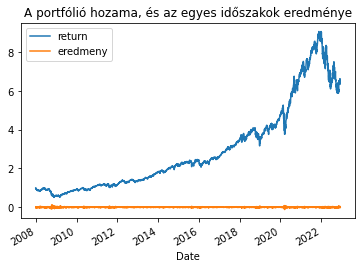

In [168]:
#Ellenőrzések
#print(df_hozam2['return'],df_hozam2['eredmeny'])
#df_hozam2[['eredmeny','return']].plot()
df_hozam2[['return','eredmeny']].plot(title="A portfólió hozama, és az egyes időszakok eredménye")
plt.show()


In [ ]:
#A legiksebb és legnagyobb érték kiszámolása
#kicsi=min(df_hozam2['return'])
#nagy=max(df_hozam2['return'])
#print(nagy-kicsi)

In [170]:
def hozamdf(df1,df2, ww):

  adatsor=df1.copy() #így annyi sorból áll, mint az eredeti df
  adatsor['eredmeny']=0
  for i in range(len(df1.columns)-2):
    adatsor['eredmeny']=adatsor['eredmeny']+df2[df1.columns[i]]*ww[i] #a súlyokkal súlyozunk, hogy megfelelő legyen a hozam


  adatsor['return']=np.zeros
  adatsor['return'][0]=1
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot

  for i in range(len(adatsor['eredmeny'])-1):
    adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]

  return adatsor['return']

<ipython-input-170-938e929cdcf4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][0]=1
<ipython-input-170-938e929cdcf4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot
<ipython-input-170-938e929cdcf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]


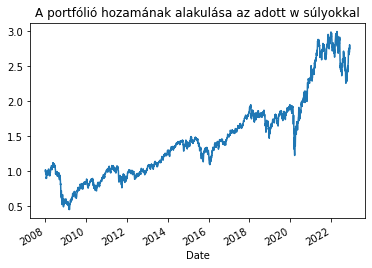

In [171]:
#Ellenőrzés
qq=hozamdf(df_hozam2,df_ret,w)
#print(qq.head(-5))
fig=qq.plot(title="A portfólió hozamának alakulása az adott w súlyokkal",
            )
#fig.legend="return"

plt.show(fig)

In [173]:
def maxmin(ww):
  qq=hozamdf(df_hozam2,df_ret,ww)
  kicsi=min(qq)
  a=0 
  for i in qq:
    a=a+1
    if i == kicsi: 
      break
  nagy=0
  for j in range(0,a):
    if qq[j]>nagy:
      nagy=qq[j]
  return (nagy-kicsi)/nagy


In [174]:
drawd=maxmin(w)
print(drawd)

<ipython-input-170-938e929cdcf4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][0]=1
<ipython-input-170-938e929cdcf4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot
<ipython-input-170-938e929cdcf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]


0.5982482346449063


####Optimalizálás

In [175]:
#Szükséges package-ek importálása
import seaborn as sns

import scipy

In [177]:
#Egy egyszerűen ellenőrizhető példafüggvény
def proba(ww):
  return ww[0]/ww[1]+ww[2]+ww[3]+ww[4]

In [178]:
#Az optimalizálandó függvény
fun3 = lambda x: maxmin(x) #ide proba(x) is jöhet tesztelni

In [179]:
#Határok és korlátok
bounds=((0,None),(0,None),(0,None),(0,None),(0,None))
cons=({'type': 'eq', 'fun': lambda ww: np.sum(ww)-1})

In [180]:
#Az optimalizálás (~3 min volt nekem)
megoldas3=scipy.optimize.minimize(fun3, (0.1,0.1,0.1,0.1,0.6), method='SLSQP',
                        bounds=bounds,
                        constraints=cons)

<ipython-input-170-938e929cdcf4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][0]=1
<ipython-input-170-938e929cdcf4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot
<ipython-input-170-938e929cdcf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]


In [181]:
#Az eredmény
print(megoldas3)

     fun: 0.0013094664321119387
     jac: array([0.04902092, 0.03481957, 0.00727025, 0.00130966, 0.03637855])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([8.46084684e-15, 7.95117291e-15, 0.00000000e+00, 1.00000000e+00,
       3.09274075e-14])


In [182]:
#Ellenzőrzés
sum(megoldas3['x'])

1.0000000000000064

In [183]:
#És a portfólió alakulása az időben
drawd=maxmin(megoldas3['x'])
print(drawd)


<ipython-input-170-938e929cdcf4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][0]=1
<ipython-input-170-938e929cdcf4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot
<ipython-input-170-938e929cdcf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]


0.0013094664321119387


In [184]:
qq=hozamdf(df_hozam2,df_ret,megoldas3['x'])
#print(qq.head(-5))
#qq.plot()
print(min(qq))

<ipython-input-170-938e929cdcf4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][0]=1
<ipython-input-170-938e929cdcf4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][1]=adatsor['return'][0]*(1+adatsor['eredmeny'][1]) #kiszámítjuk a hozamot
<ipython-input-170-938e929cdcf4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatsor['return'][i+1]=(adatsor['eredmeny'][i+1]+1)*adatsor['return'][i]


0.9986905335678881


####Optimalizálás más feltételekkel

In [ ]:
cons2=({'type': 'eq', 'fun': lambda ww: np.sum(ww)-1},
       {'type': 'ineq', 'fun': lambda ww: ww[1]-0.05})

In [ ]:
#Az optimalizálás (~3 min volt nekem)
megoldas3b=scipy.optimize.minimize(fun3, (0.1,0.1,0.1,0.1,0.6), method='SLSQP',
                        bounds=bounds,
                        constraints=cons2)

In [ ]:
print(megoldas3b)

##Példa a minimalizálásra

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [ ]:
fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2

bnds = ((0, None), (0, None))

cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
        {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
        {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})

res = scipy.optimize.minimize(fun, (2, 0), method='SLSQP', bounds=bnds,
               constraints=cons)

In [ ]:
res